# Laboratorio 2 - Series de tiempo
## Precios promedio

##### Sebastian Aristondo 20880
##### Daniel Gonzalez 20293

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from pmdarima import auto_arima

In [44]:
import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

## 1. Análisis expolatorio

### 1.2 Precio Promedio

In [45]:
consumo = pd.read_csv('Precios_promedio.csv', sep=',')
consumo.head()

,FECHA,GTQ/USD,Superior,Regular,Diesel,Bunker,Glp Cilindro 25Lbs .GTQ/CIL 25 LB,Glp Cilindro 25Lbs. GTQ/LB
0,01/Jan/2021,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
1,02/Jan/2021,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
2,03/Jan/2021,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
3,04/Jan/2021,7.79417,21.91,21.11,17.61,13.45,99.0,3.96
4,05/Jan/2021,7.79369,21.91,21.11,17.61,13.45,99.0,3.96


In [46]:
columns_to_convert = [col for col in consumo.columns if col != 'FECHA']
consumo[columns_to_convert] = consumo[columns_to_convert].apply(lambda x: x.str.replace(',', '').astype(float) if x.dtype == 'object' else x)\

consumo.describe()

,GTQ/USD,Superior,Regular,Diesel,Bunker,Glp Cilindro 25Lbs .GTQ/CIL 25 LB,Glp Cilindro 25Lbs. GTQ/LB
count,944.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000
mean,7.761312,32.364916,31.208502,28.503059,18.238027,123.723745,4.949061
std,0.059130,4.552204,4.221649,6.040627,2.721544,8.442288,0.337845
min,7.650900,21.910000,21.110000,17.610000,13.400000,99.000000,3.960000
25%,7.719990,28.790000,27.990000,23.090000,16.390000,120.000000,4.800000
50%,7.738020,33.300000,31.840000,27.980000,17.410000,122.000000,4.880000
75%,7.807210,35.572500,34.260000,33.750000,19.475000,122.000000,4.880000
max,7.930240,43.240000,40.500000,41.270000,25.100000,147.000000,5.880000


In [47]:
consumo['FECHA'] = pd.to_datetime(consumo['FECHA'], format='%d/%b/%Y')
consumo.dtypes

FECHA                                 datetime64[ns]
GTQ/USD                                      float64
Superior                                     float64
Regular                                      float64
Diesel                                       float64
Bunker                                       float64
 Glp Cilindro 25Lbs .GTQ/CIL 25 LB           float64
Glp Cilindro 25Lbs. GTQ/LB                   float64
dtype: object

In [48]:
nans_por_columna = consumo.isna().sum()
consumo = consumo.fillna(0)
print("Valores NaN por columna:")
print(nans_por_columna)

Valores NaN por columna:
FECHA                                 0
GTQ/USD                               4
Superior                              0
Regular                               0
Diesel                                0
Bunker                                0
 Glp Cilindro 25Lbs .GTQ/CIL 25 LB    0
Glp Cilindro 25Lbs. GTQ/LB            0
dtype: int64


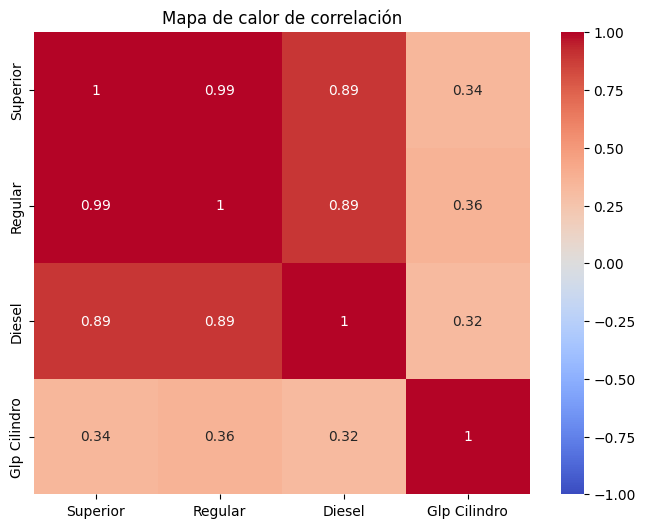

In [49]:

consumo["Glp Cilindro"] = consumo["Glp Cilindro 25Lbs. GTQ/LB"]
columnas_interes = ["Superior", "Regular", "Diesel", "Glp Cilindro"]
consumo_numericas = consumo[columnas_interes]
correlation_matrix = consumo_numericas.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de calor de correlación')
plt.show()

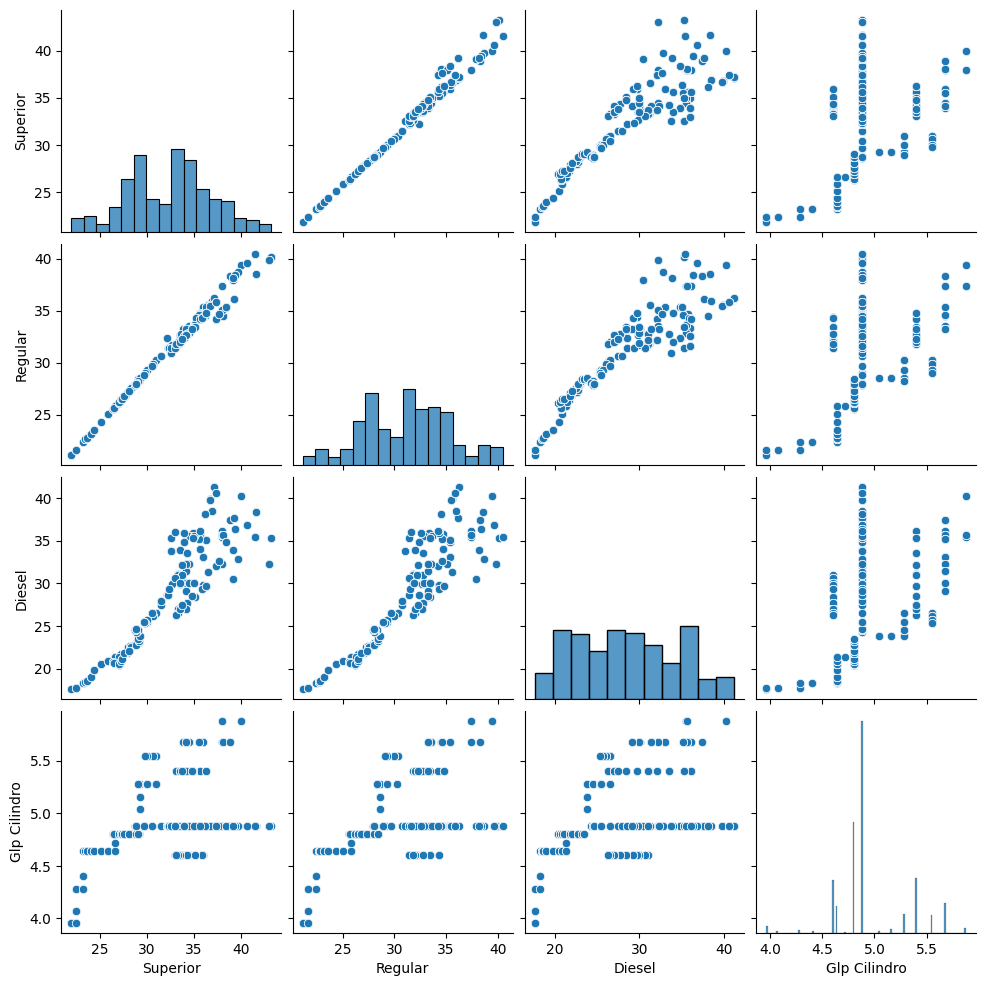

In [50]:
grid = sns.pairplot(consumo_numericas)
plt.show()

In [51]:
normality_test = consumo_numericas.apply(normaltest)
print("Resultados de test de normalidad: \n", normality_test)

Resultados de test de normalidad: 
     Superior   Regular        Diesel  Glp Cilindro
0  13.693900  8.744152  1.781288e+02  6.565420e+01
1   0.001063  0.012625  2.088471e-39  5.538240e-15


Ninguna de las distribuciones de las variables interesantes es normal.

In [52]:
consumo["Mes"] = consumo["FECHA"].dt.month
consumo["Año"] = consumo["FECHA"].dt.year

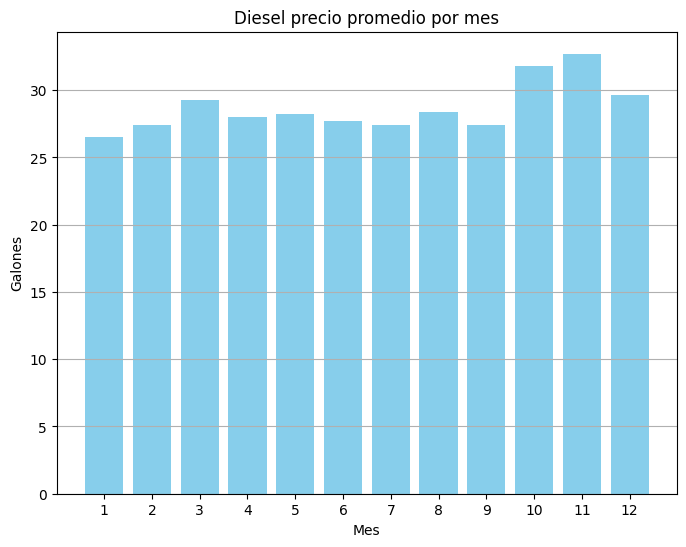

In [53]:
suma_por_mes = consumo.groupby('Mes')['Diesel'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Diesel precio promedio por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

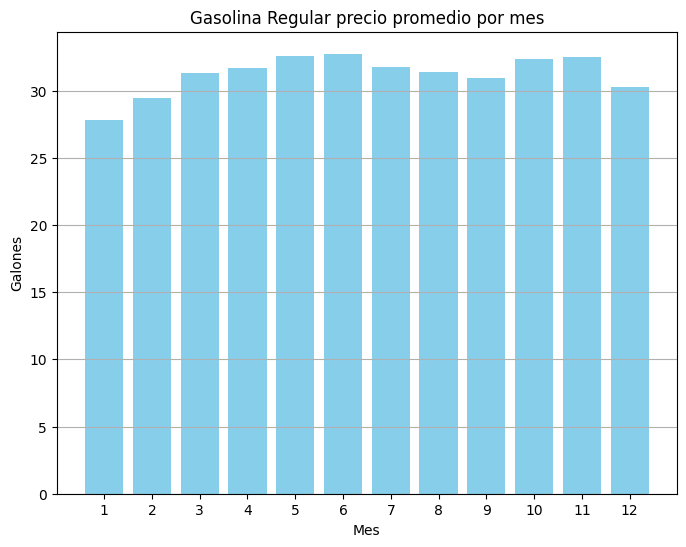

In [54]:
suma_por_mes = consumo.groupby('Mes')['Regular'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gasolina Regular precio promedio por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

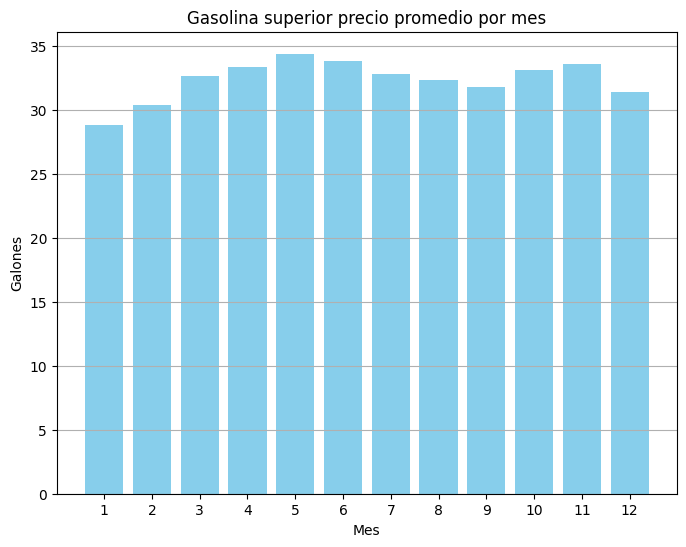

In [55]:
suma_por_mes = consumo.groupby('Mes')['Superior'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gasolina superior precio promedio por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

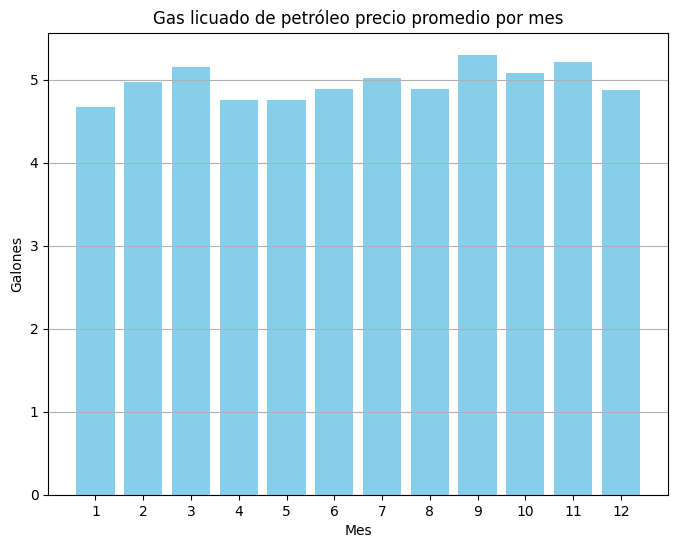

In [56]:
suma_por_mes = consumo.groupby('Mes')['Glp Cilindro'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gas licuado de petróleo precio promedio por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

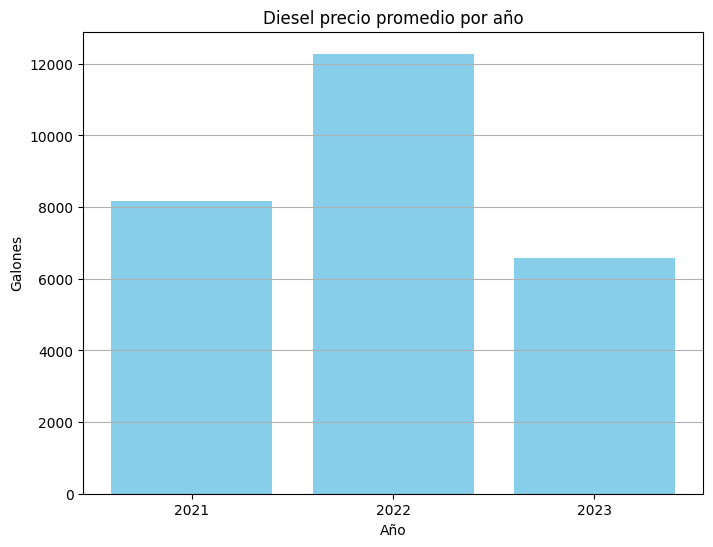

In [57]:
suma_por_mes = consumo.groupby('Año')['Diesel'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Diesel precio promedio por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

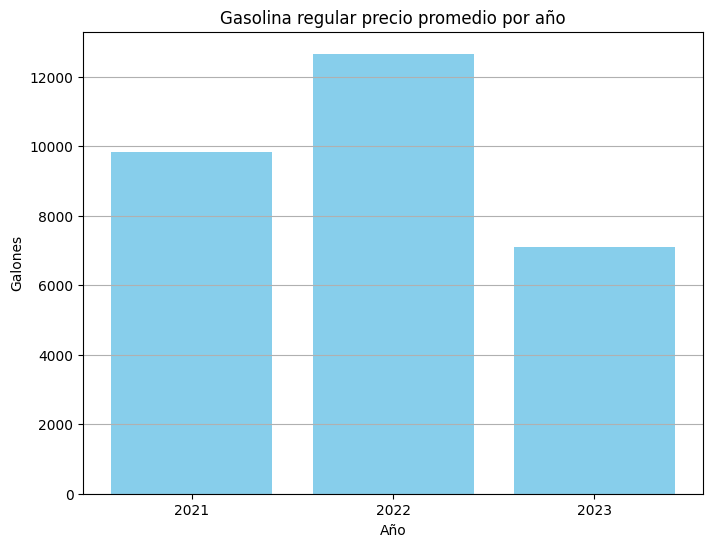

In [58]:
suma_por_mes = consumo.groupby('Año')['Regular'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Gasolina regular precio promedio por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

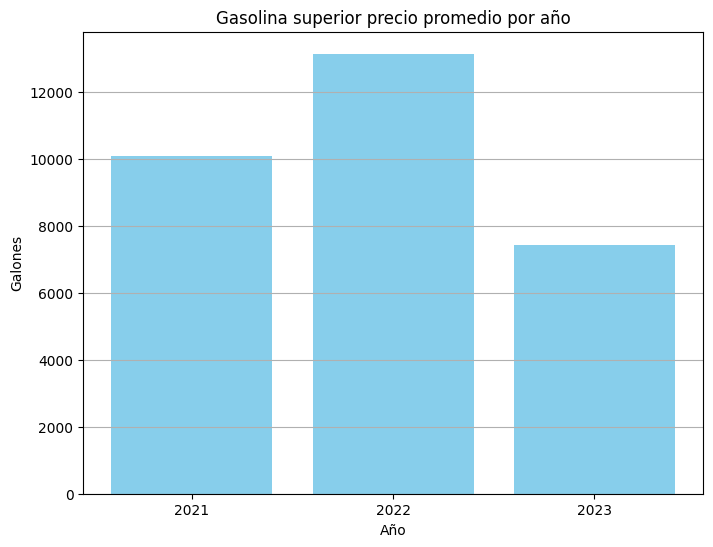

In [59]:
suma_por_mes = consumo.groupby('Año')['Superior'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Gasolina superior precio promedio por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

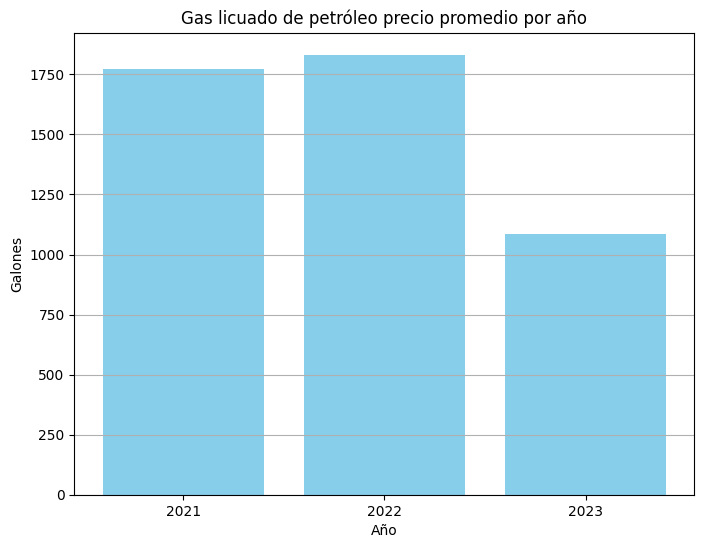

In [60]:
suma_por_mes = consumo.groupby('Año')['Glp Cilindro'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Gas licuado de petróleo precio promedio por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

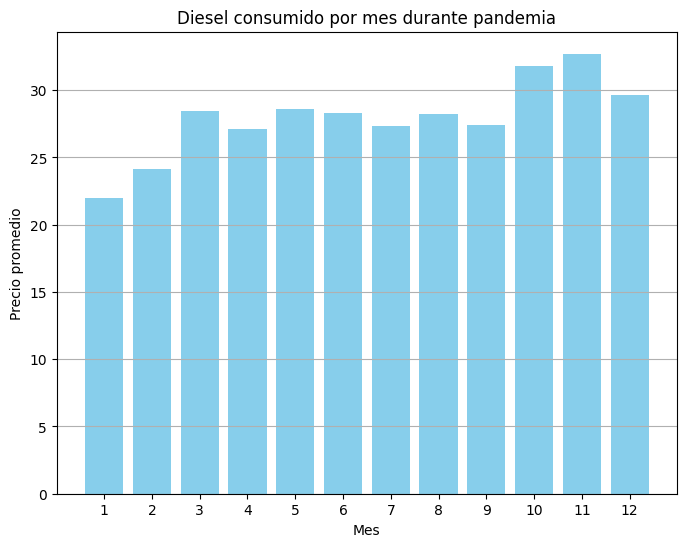

In [61]:
datos_pandemia = consumo[(consumo["FECHA"].dt.year >= 2020) & (consumo["FECHA"].dt.year <= 2022)]
suma_por_mes = datos_pandemia.groupby('Mes')['Diesel'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Precio promedio')
plt.title('Diesel consumido por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

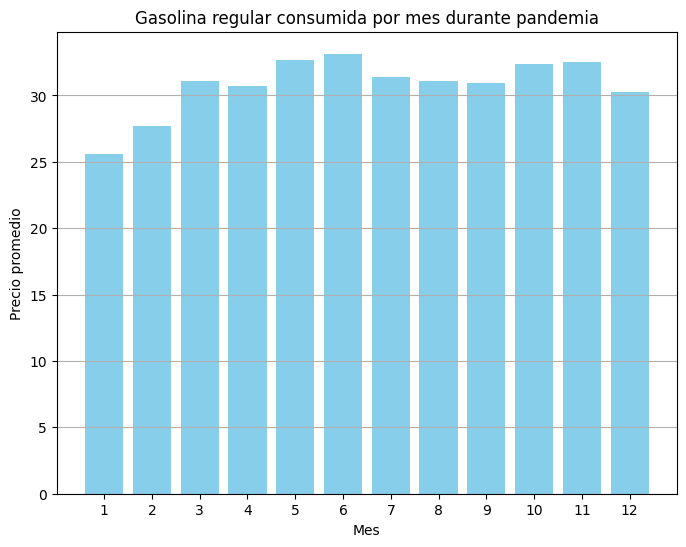

In [62]:
suma_por_mes = datos_pandemia.groupby('Mes')['Regular'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Precio promedio')
plt.title('Gasolina regular consumida por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

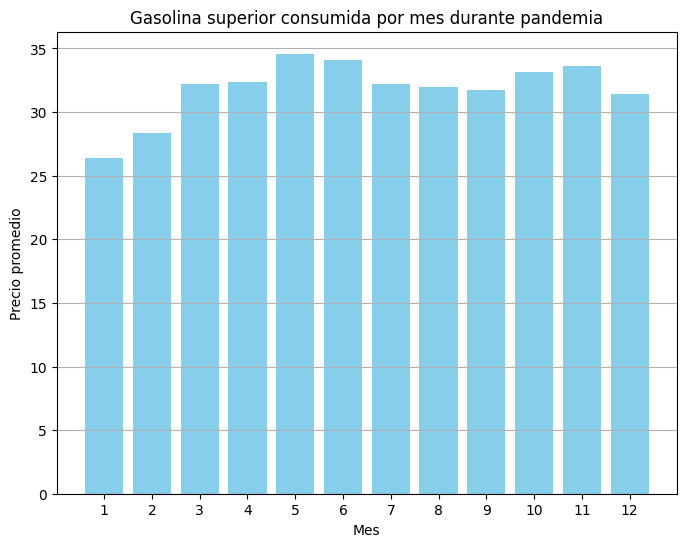

In [63]:
datos_pandemia = consumo[(consumo["FECHA"].dt.year >= 2020) & (consumo["FECHA"].dt.year <= 2022)]
suma_por_mes = datos_pandemia.groupby('Mes')['Superior'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Precio promedio')
plt.title('Gasolina superior consumida por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

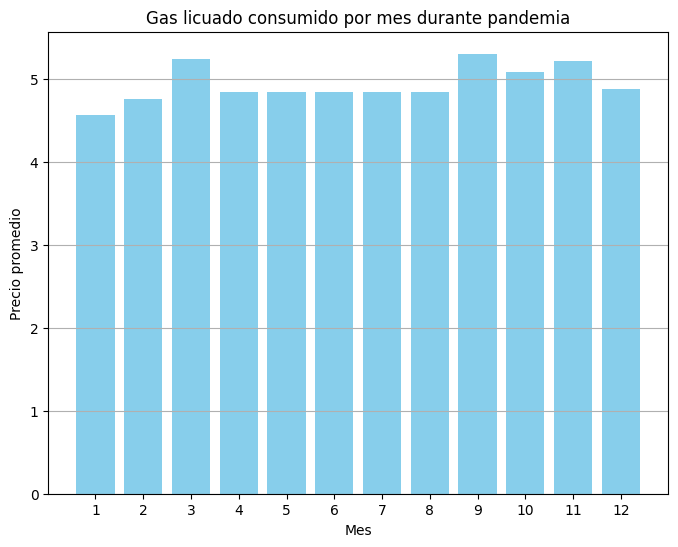

In [64]:
datos_pandemia = consumo[(consumo["FECHA"].dt.year >= 2020) & (consumo["FECHA"].dt.year <= 2022)]
suma_por_mes = datos_pandemia.groupby('Mes')['Glp Cilindro'].mean().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Precio promedio')
plt.title('Gas licuado consumido por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

## 2. Elección de series de tiempo

* Serie 1: Consumo de diesel
* Serie 2: Importacion de gasolina regular
* Serie 3: Precio de gasolina super

## 3. Análisis de series de tiempo

### 3.1 Consumo de diesel

#### a. Especifique Inicio, fin, y frecuencia.

In [65]:
print("Inicio de frecuencia: ", min(consumo["FECHA"]))
print("Fin de frecuencia: ", max(consumo["FECHA"]))
print("La frecuencia es diaria")

Inicio de frecuencia:  2021-01-01 00:00:00
Fin de frecuencia:  2023-08-06 00:00:00
La frecuencia es diaria


#### b. Haga un gráfico de la serie y explique qué información puede obtener a primera vista.

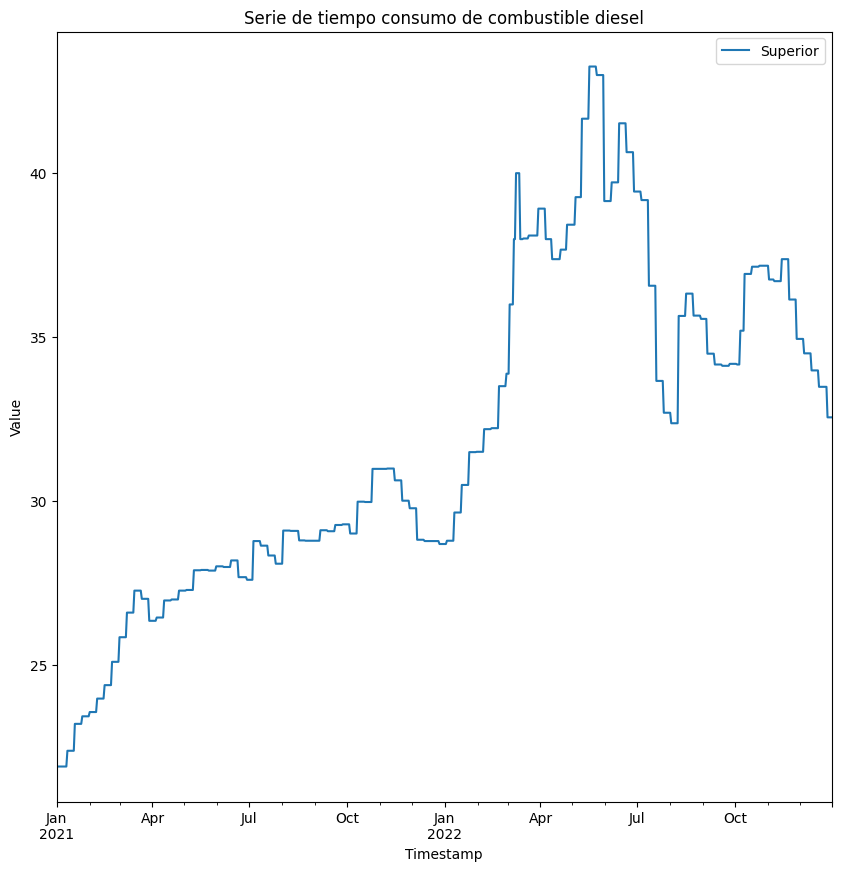

In [66]:
promedio_super = consumo[["FECHA", "Superior"]].copy()
promedio_super["FECHA"] = pd.to_datetime(promedio_super["FECHA"])
promedio_super.set_index("FECHA",inplace=True)
promedio_super_train = promedio_super[promedio_super.index < "2023-01-01"].copy()
promedio_super_test = promedio_super[promedio_super.index >= "2023-01-01"].copy()

#promedio_super_train.tail(50)

promedio_super_train.plot(figsize=(10, 10))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Serie de tiempo consumo de combustible diesel')
plt.show()

A primera vista se puede observar que existe una tendencia a la alza en la serie de tiempo de consumo de gasolina superior. En junio de 2022 se alcanza un maximo histórico de consumo. Luego en julio vemos que tiene una caida  y rebota en la resistencia de 32 luego de eso el consumo queda encerrado en un canal horizontal donde el piso es 32 y el techo es 37

#### c. Haga un gráfico de la serie y explique qué información puede obtener a primera vista.

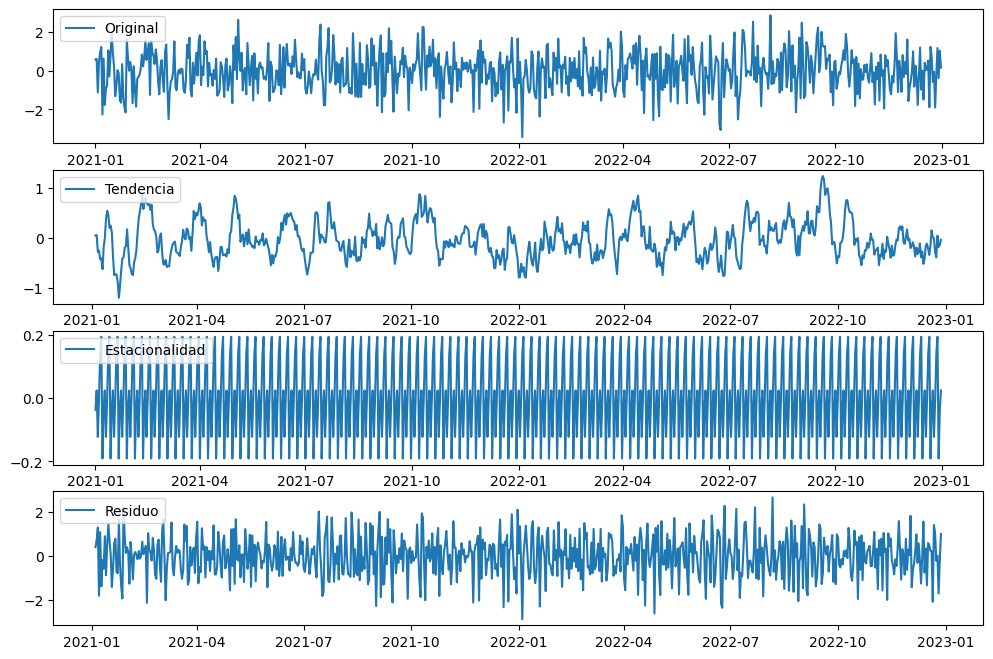

In [67]:
# Crear un índice de fechas para la serie temporal (puedes omitir esta parte si ya tienes un DataFrame con fechas como índice)
date_rng = pd.date_range(start=min(promedio_super_train.index), end=max(promedio_super_train.index), freq='D')
values = np.random.randn(len(date_rng))  # Valores aleatorios para el ejemplo

# Crear el DataFrame con la serie temporal
ts_df = pd.DataFrame(values, index=date_rng, columns=['Value'])

# Realizar la descomposición
result = seasonal_decompose(ts_df['Value'], model='additive', period=7)  # Puedes cambiar 'additive' a 'multiplicative' según la naturaleza de la estacionalidad

# Visualizar los componentes
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(ts_df['Value'], label='Original')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuo')
plt.legend(loc='upper left')
plt.show()

Los datos muestran que no hay una tendencia fija en el tiempo,tambien por la forma de la grafica podemos que no es estacionaria en media ni en varianza. Si se puede ver un patron en la estacionalidad y os residuos parecieran ser aleatorios

#### d. Determine si es necesario transformar la serie. Explique.

Se aplicará boxcox a la serie para poder hacerla estacionaria en varianza. Como se mencionó, se puede observar en la serie de tiempo diferencias entre las varianzas.

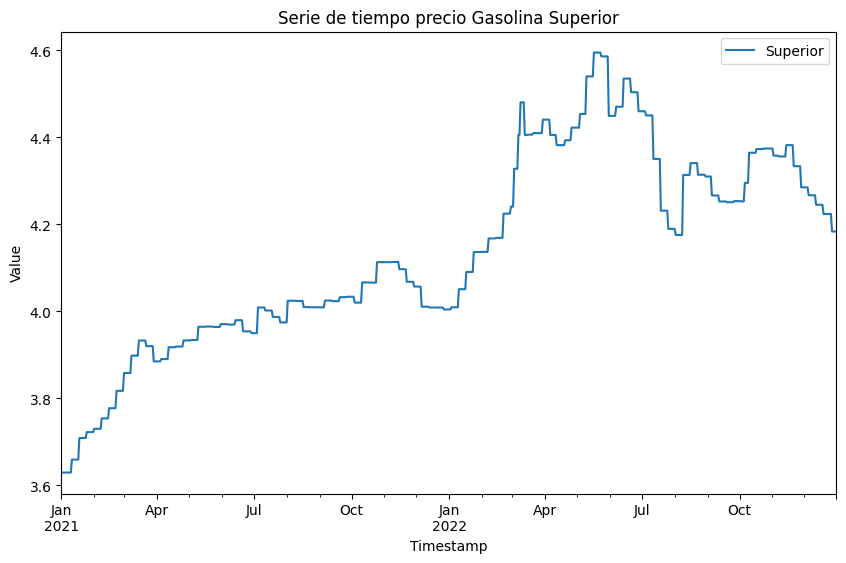

In [68]:
transformed_values, lambda_value = boxcox(promedio_super_train['Superior'])
promedio_super_original = promedio_super_train.copy()
promedio_super_train_2 = promedio_super_train.copy()
promedio_super_test_2 = promedio_super_test.copy()
promedio_super_train['Superior'] = transformed_values
promedio_super_train.plot(figsize=(10, 6))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Serie de tiempo precio Gasolina Superior')
plt.show()


#### d. Explique si no es estacionaria en media. Para esto:

##### i. Haga el gráfico de autocorrelación y úselo para explicar la no estacionariedad en media.

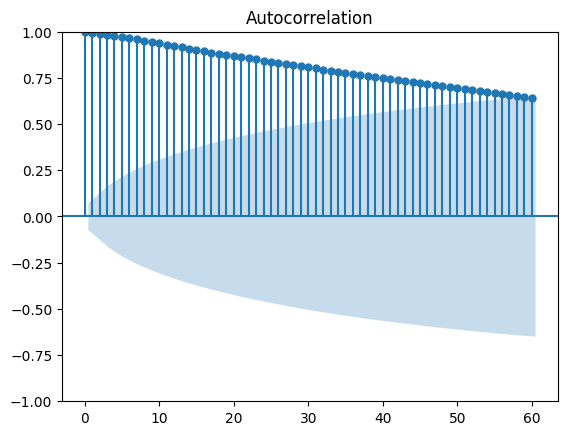

In [69]:
fig = plot_acf(promedio_super_train['Superior'], lags=60)
plt.show()

Se puede observar que los valores de la autocorrelación no decrecen rápidamente a 0. Esto indica que el proceso no es estacionario, porque existe una tendencia en la media.

##### ii. Básese en los valores de estadísticos como la prueba de Dickey-Fuller Aumentada para corroborar la no estacionariedad en media. ¿Qué es necesario hacer para hacerla estacionaria en media en caso de que no lo sea?

In [70]:
def check_stationarity(timeseries):
    # Realizar la prueba ADF
    resultado_adf = adfuller(promedio_super_train)

    # Extraer los resultados importantes de la prueba
    adf_stat = resultado_adf[0]
    p_valor = resultado_adf[1]
    valores_criticos = resultado_adf[4]

    # Imprimir los resultados
    print("Estadístico ADF:", adf_stat)
    print("P-valor:", p_valor)
    print("Valores críticos:")
    for key, value in valores_criticos.items():
        print(f"  {key}: {value}")
check_stationarity(promedio_super_train)

Estadístico ADF: -2.3275520967997636
P-valor: 0.16323576640554155
Valores críticos:
  1%: -3.439439614524914
  5%: -2.865551414233055
  10%: -2.5689061365397747


Por medio de ADF se puede observar que la serie no es estacionaria, al tener un p-value de 0.15, entonces no se puede rechazar la hipótesis nula por lo que se procede a diferenciarla.

In [71]:
promedio_super_train = promedio_super_train.diff().dropna()
check_stationarity(promedio_super_train)

Estadístico ADF: -7.571646487533849
P-valor: 2.8309507134424362e-11
Valores críticos:
  1%: -3.439439614524914
  5%: -2.865551414233055
  10%: -2.5689061365397747


Una vez se realizó una diferenciación, se volvió a realizar el test ADF y se logró determinar que ahora la serie de tiempo es estacionaria, al obtener un valor menor a la significancia.

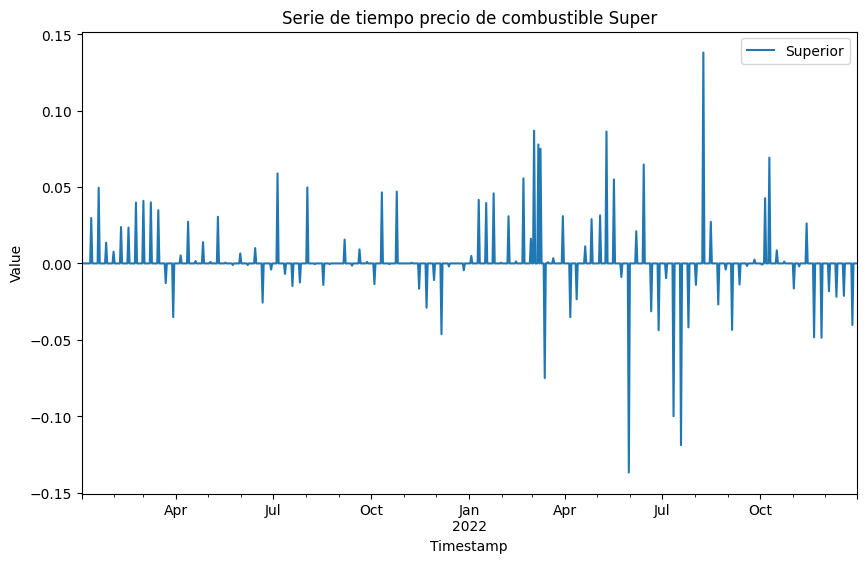

In [72]:
promedio_super_train.plot(figsize=(10, 6))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Serie de tiempo precio de combustible Super')
plt.show()

En el gráfico no se puede observar una tendencia, si no que parece ser que la media es constante.

#### f. Una vez analizada la serie, elija los parámetros p, q y d del modelo ARMA o ARIMA que utilizará para predecir. Explique en qué se basó para darle valor a estos parámetros, basándose en las funciones de autocorrelación y autocorrelación parcial. Si usa la función autoarima de R, determine y explique si tiene sentido el modelo propuesto.

### Autocorrelación parcial

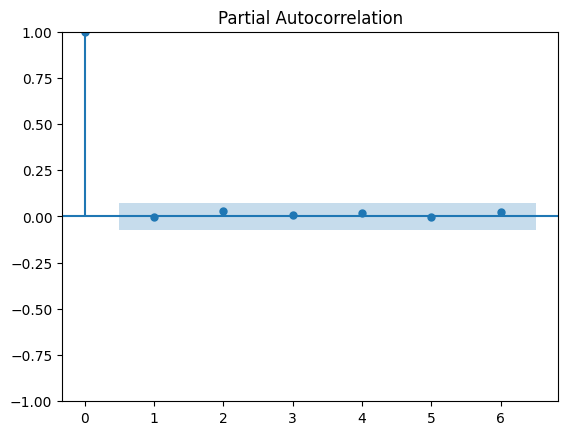

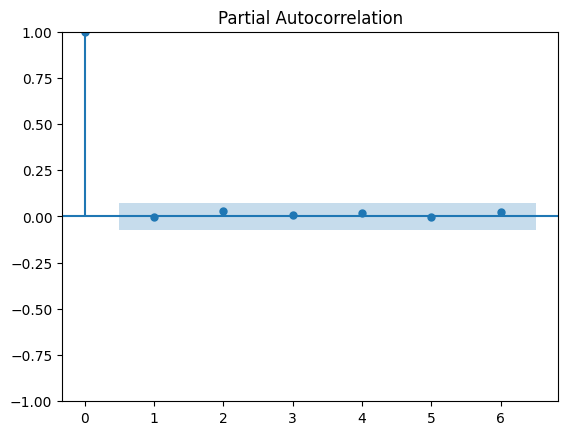

In [73]:
plot_pacf(promedio_super_train, lags=6) #p

### Autocorrelación

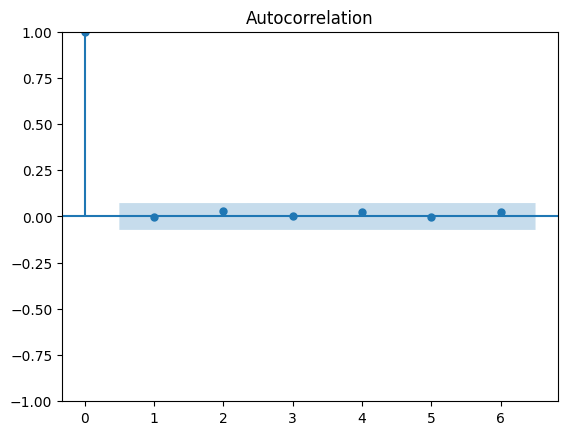

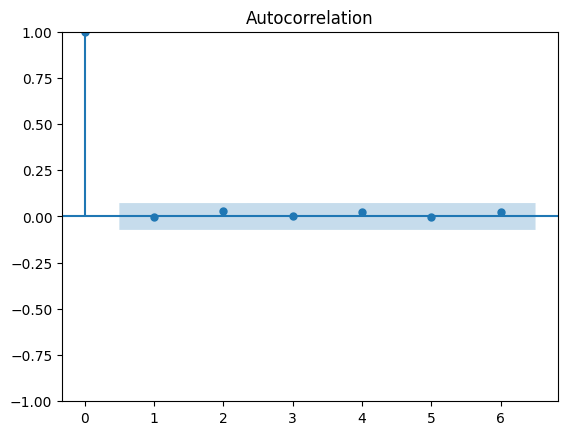

In [74]:
plot_acf(promedio_super_train, lags=6)

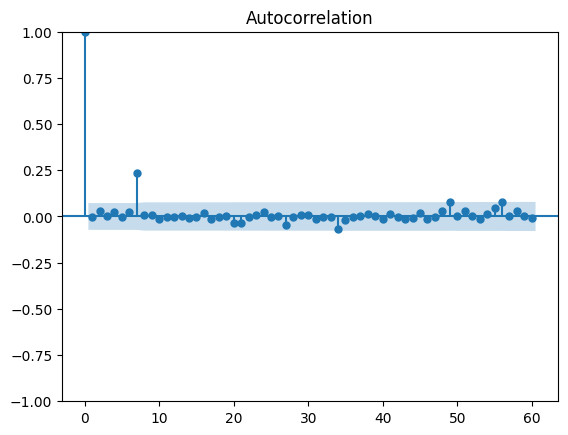

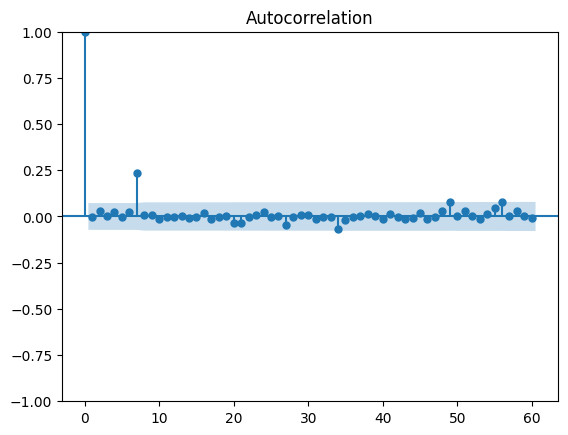

In [75]:
plot_acf(promedio_super_train, lags=60)#q

En el análisis de Autocorrelación no se observa un patrón claro. No se usará SARIMA, porque no se pudo encontrar una frecuencia clara.

Se crearán dos modelos de ARIMA con parámetros: 
* p = 1, d = 1, q = 1
* p = 2, d = 1, q = 1



In [76]:
modelo1 = sm.tsa.ARIMA(promedio_super_train_2, order=(1, 1, 1))
resultado_m1 = modelo1.fit()
print(resultado_m1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9020      0.127      7.128      0.000       0.654       1.150
ma.L1         -0.8731      0.157     -5.574      0.000      -1.180      -0.566
sigma2         0.1407      0.002     69.815      0.000       0.137       0.145


In [77]:
modelo2 = sm.tsa.ARIMA(promedio_super_train_2, order=(2, 1, 1))
resultado_m2 = modelo2.fit()
print(resultado_m2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8359      0.421      1.987      0.047       0.011       1.660
ar.L2          0.0425      0.332      0.128      0.898      -0.609       0.694
ma.L1         -0.8411      0.144     -5.841      0.000      -1.123      -0.559
sigma2         0.1405      0.002     75.201      0.000       0.137       0.144


In [78]:
stepwise_fit = auto_arima(promedio_super_original, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,  # Maximum values for p and q
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',  # Ignore if model fails to converge
                          suppress_warnings=True,  # Suppress convergence warnings
                          stepwise=True)  # Use a stepwise search approach

# Print the summary of the best model
print(stepwise_fit.summary())

# Fit the best model
best_model = stepwise_fit.fit(promedio_super)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2615.459, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=918.182, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1951.412, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2624.490, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1123.298, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=848.105, Time=1.97 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.00 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2612.482, Time=1.22 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=849.878, Time=2.39 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=849.906, Time=2.38 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1952.499, Time=1.90 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=852.019, Time=3.88 sec
 ARIMA(1,0,0)(2,1,0)[12]             : 

In [79]:
print("Parámetros de mejor modelo con autoarima: ", stepwise_fit.order)

Parámetros de mejor modelo con autoarima:  (1, 0, 0)


### g. Haga varios modelos ARIMA, y diga cuál es el mejor de ellos para estimar los datos de la serie. Para esto analice los residuos y las métricas AIC y/ BIC.
Los modelos se habían hecho previamente.

#### Modelo 1

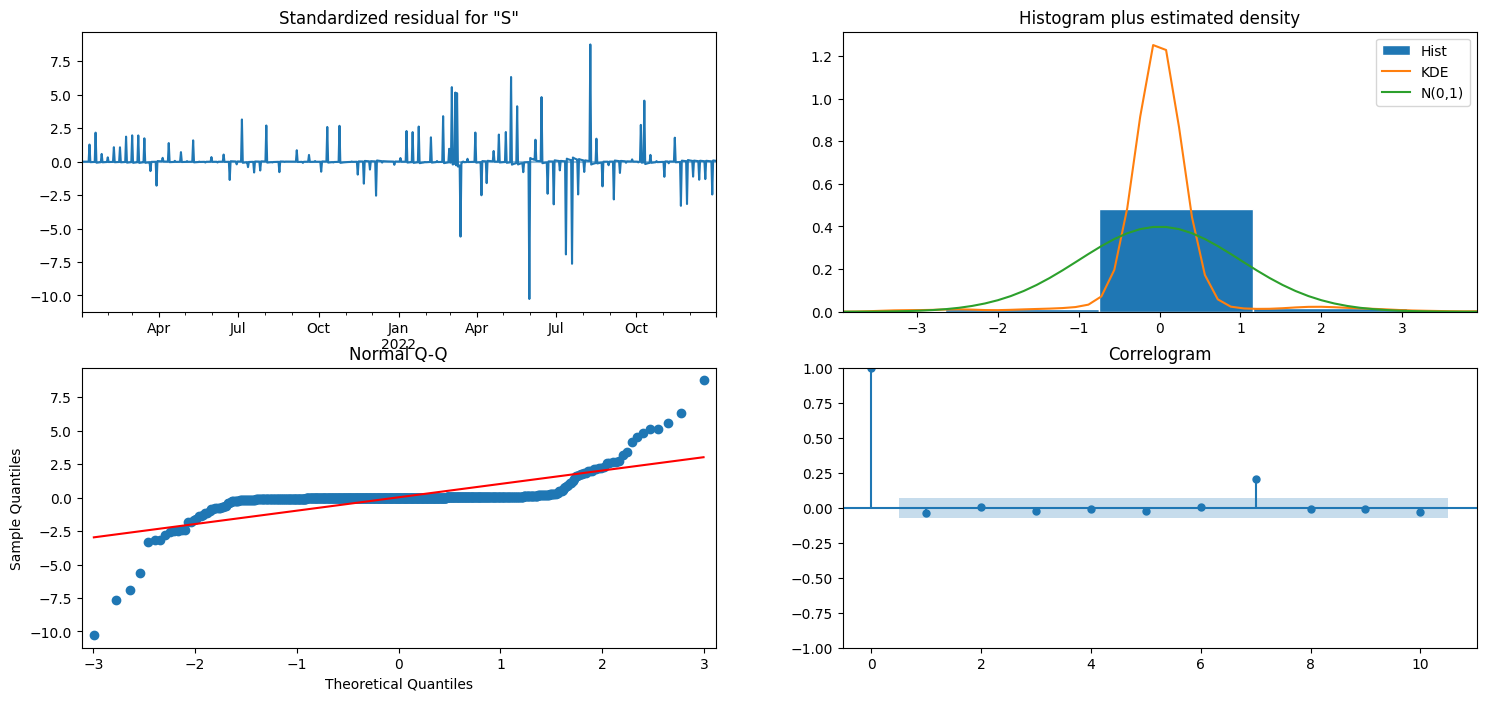

In [80]:
resultado_m1.plot_diagnostics(figsize=(18, 8))
plt.show()

#### Modelo 2

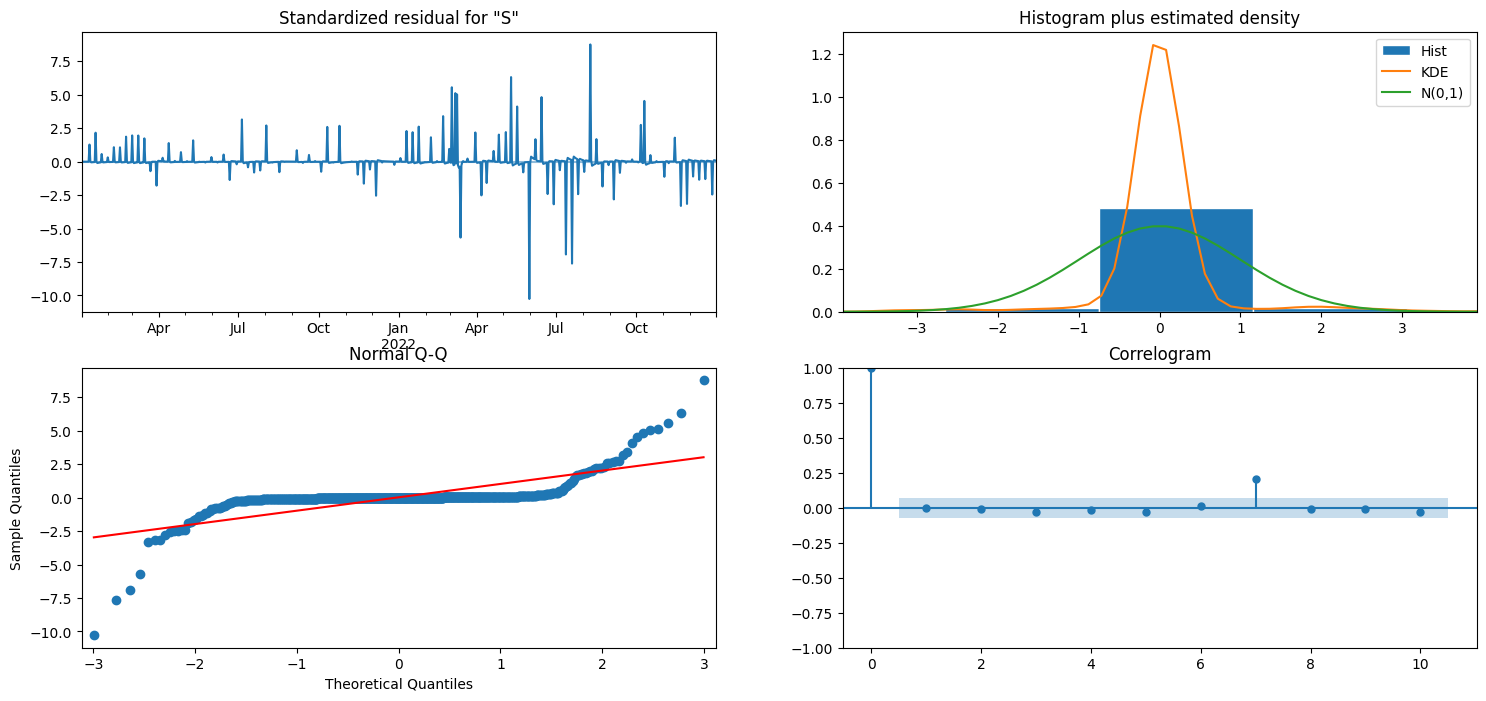

In [81]:
resultado_m2.plot_diagnostics(figsize=(18, 8))
plt.show()

#### Modelo 3

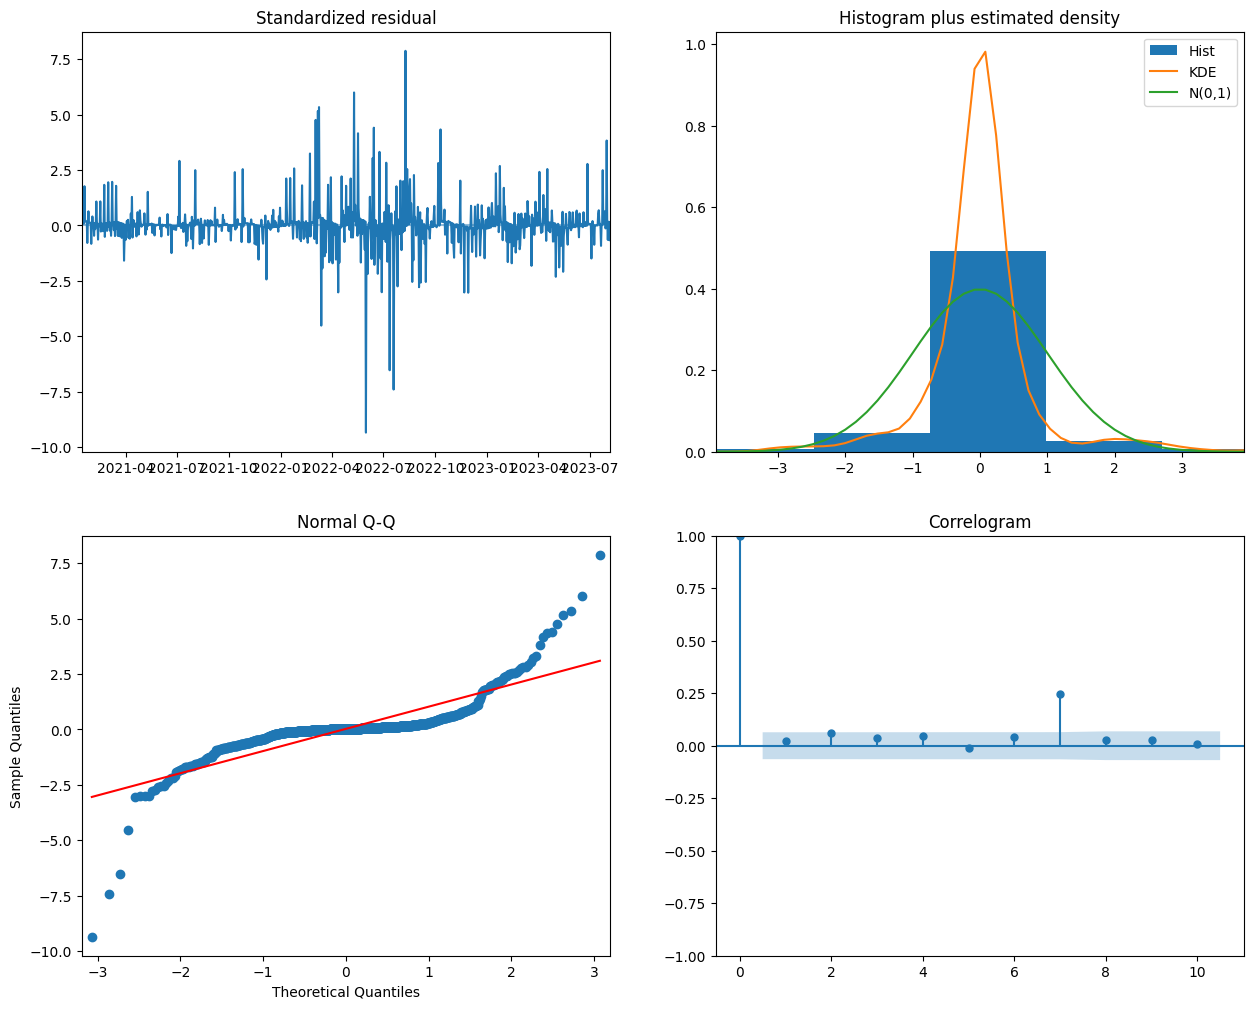

In [82]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [83]:
print("AIC para modelo 1:", resultado_m1.aic)
print("BIC para modelo 1:", resultado_m1.bic)
print("\nAIC para modelo 2:", resultado_m2.aic)
print("BIC para modelo 2:", resultado_m2.bic)
print("\nAIC para modelo 3:", best_model.aic())
print("BIC para modelo 3:", best_model.bic())

AIC para modelo 1: 645.329688893751
BIC para modelo 1: 659.104710089777

AIC para modelo 2: 646.1371417408711
BIC para modelo 2: 664.5038366689057

AIC para modelo 3: 971.8030571492419
BIC para modelo 3: 991.1695190551523


En este caso realizamos tres modelos, dos manualmente y otro con autoarima. Se puede evidenciar que todos los modelos son malos. En los tres modelos se realizó el análisis de residuales y se puede observar que no están distribuídos uniformemente. Esto se observa tanto en la distribución como en el Q-Q plot. A pesar de que en el correlograma no se observa un patrón. Por otra parte, las medidas de AIC y BIC son bastante altas, siendo autoarima el peor de los 3. El primero modelo creado, con p = 1, d = 1 y q = 1 es el mejor.

#### h. Haga un modelo usando el algoritmo de redes neuronales. Compárelo con los modelos del inciso anterior. ¿Cuál funcionó mejor?

In [84]:
# En esta ocasion solo usaremos train y test, validation lo omitiremos para simpleza del ejercicio
# NO CAMBIEN NADA DE ESTA CELDA POR FAVOR
p_train=0.8
p_test=0.2

datos = promedio_super[['Superior']].values.astype('float32')

# Definimos el tamaño de las particiones
num_train = int(len(datos)*p_train)
num_test = int(len(datos)*p_test)


# Dividir las secuencias en las particiones
train = datos[:num_train]
test = datos[num_train:]

In [43]:
import torch

def create_timeseries_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

# EL VALOR DE LB SÍ LO PUEDEN CAMBIAR SI LO CONSIDERAN NECESARIO
lb = 5
X_train, y_train = create_timeseries_dataset(train, lookback=lb)
#X_validation, y_validation = create_timeseries_dataset(validation, lookback=lb)
X_test, y_test = create_timeseries_dataset(test, lookback=lb)

print(X_train.shape, y_train.shape)
#print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

torch.Size([753, 5, 1]) torch.Size([753, 5, 1])
torch.Size([185, 5, 1]) torch.Size([185, 5, 1])


In [44]:
import torch.nn as nn

class CustomModelLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1 , hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        # YOUR CODE HERE
        x, _ = self.lstm(x)
        x = self.linear(x)
        # raise NotImplementedError()
        return x

In [45]:
import torch.optim as optim
import torch.utils.data as data
import random
seed_ = 1234
# NOTEN QUE ESTOY PONIENDO DE NUEVO LOS SEEDS PARA SER CONSTANTES
random.seed(seed_)
np.random.seed(seed_)
 
model = CustomModelLSTM()
# Optimizador y perdida
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
# Observen como podemos también definir un DataLoader de forma snecilla
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)
 
# Pueden cambiar el número de epocas en esta ocasión con tal de llegar al valor de la metrica de desempeño
n_epochs = 3010

# Perdidas
loss_train = []
loss_test = []

# Iteramos sobre cada epoca
for epoch in range(n_epochs):
    # Colocamos el modelo en modo de entrenamiento
    model.train()
    
    # Cargamos los batches
    for X_batch, y_batch in loader:
        # Obtenemos una primera prediccion
        y_pred = model(X_batch)
        # Calculamos la perdida
        loss = loss_fn(y_pred, y_batch)
        # Reseteamos la gradiente a cero
        #   sino la gradiente de previas iteraciones se acumulará con las nuevas
        optimizer.zero_grad()
        # Backprop
        loss.backward()
        # Aplicar las gradientes para actualizar los parametros del modelo
        optimizer.step()
        
    # Validación cada 100 epocas
    if epoch % 100 != 0 and epoch != n_epochs-1:
        continue
    # Colocamos el modelo en modo de evaluación
    model.eval()
    
    # Deshabilitamos el calculo de gradientes
    with torch.no_grad():
        # Prediccion
        y_pred = model(X_train)
        # Calculo del RMSE - Root Mean Square Error
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        # Prediccion sobre validation
        y_pred = model(X_test)
        # Calculo del RMSE para validation
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        loss_train.append(train_rmse)
        loss_test.append(test_rmse)
        
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 27.7979, test RMSE 29.5208
Epoch 100: train RMSE 1.0218, test RMSE 0.5097
Epoch 200: train RMSE 1.0372, test RMSE 0.5416
Epoch 300: train RMSE 0.7000, test RMSE 0.3214
Epoch 400: train RMSE 0.6035, test RMSE 0.4342
Epoch 500: train RMSE 0.5902, test RMSE 0.3881
Epoch 600: train RMSE 0.6229, test RMSE 0.4505
Epoch 700: train RMSE 0.5727, test RMSE 0.3622
Epoch 800: train RMSE 0.5504, test RMSE 0.3387
Epoch 900: train RMSE 0.5485, test RMSE 0.3487
Epoch 1000: train RMSE 0.5446, test RMSE 0.3528
Epoch 1100: train RMSE 0.5264, test RMSE 0.3384
Epoch 1200: train RMSE 0.4746, test RMSE 0.3005
Epoch 1300: train RMSE 0.4469, test RMSE 0.3259
Epoch 1400: train RMSE 0.4637, test RMSE 0.3382
Epoch 1500: train RMSE 0.4334, test RMSE 0.3299
Epoch 1600: train RMSE 0.4825, test RMSE 0.3802
Epoch 1700: train RMSE 0.4281, test RMSE 0.2911
Epoch 1800: train RMSE 0.4440, test RMSE 0.2935
Epoch 1900: train RMSE 0.4633, test RMSE 0.3281
Epoch 2000: train RMSE 0.4124, test RMSE 0.2823
Ep

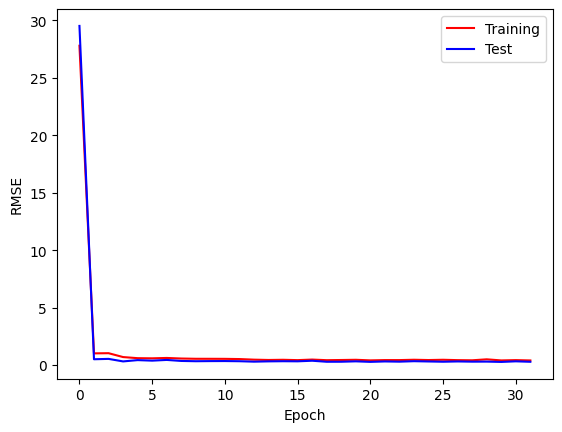

In [46]:
# Visualización del rendimiento
epoch = np.arange(len(loss_train))
plt.figure()
plt.plot(epoch, loss_train, 'r', label='Training',)
plt.plot(epoch, loss_test, 'b', label='Test')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('RMSE')
plt.show()

Como podemos ver el modelo es casi la representación de un modelo ideal, ya que la perdida de ambos es casi que identica. Esto indica que los nuevos datos estan siendo bien generalizados dando indicios de un buen modelo.

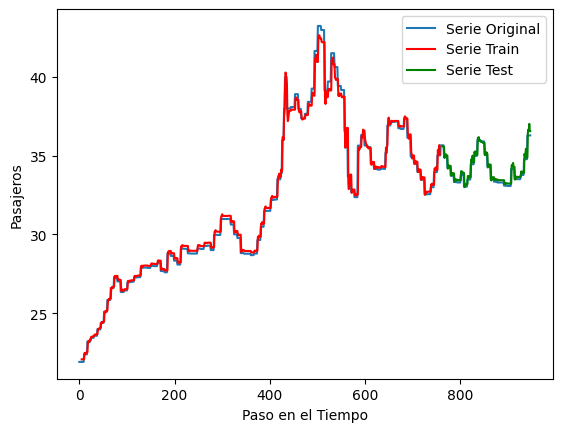

In [47]:
# Graficamos
with torch.no_grad():
    # Movemos las predicciones de train para graficar
    train_plot = np.ones_like(datos) * np.nan
    # Prediccion de train
    y_pred = model(X_train)
    # Extraemos los datos solo del ultimo paso
    y_pred = y_pred[:, -1, :]
    train_plot[lb : num_train] = model(X_train)[:, -1, :]
    # Movemos las predicciones de test
    test_plot = np.ones_like(datos) * np.nan
    test_plot[num_train + lb : len(datos)] = model(X_test)[:, -1, :]
    
plt.figure()
plt.plot(datos, label="Serie Original")
plt.plot(train_plot, c='r', label="Serie Train")
plt.plot(test_plot, c='g', label="Serie Test")
plt.xlabel('Paso en el Tiempo'), plt.ylabel('Pasajeros')
plt.legend()
plt.show()

In [48]:
y_pred = model(X_test)
residuals = y_pred - y_test
# Calculate log-likelihood of residuals
log_likelihood = -0.5 * torch.sum(torch.log(2 * np.pi * torch.var(residuals)) + (residuals ** 2) / torch.var(residuals))

# Calculate the number of parameters in your model
num_params = sum(p.numel() for p in model.parameters())

# Calculate the number of samples
num_samples = len(y_pred)

# Calculate AIC and BIC
AIC = 2 * num_params - 2 * log_likelihood
BIC = num_params * np.log(num_samples) - 2 * log_likelihood

print("AIC:", AIC)
print("BIC:", BIC)

AIC: tensor(21651.4492, grad_fn=<RsubBackward1>)
BIC: tensor(55951.4609, grad_fn=<RsubBackward1>)


Se puede observar que al usar LSTM para realizar la predicción de serie de tiempo, el AIC y BIC tiene valores demasiado altos, de 21703.05 y 56003.06 respectivamente. Sin embargo, en el gráfico se ajustó bastante bien a los datos, por lo tanto se debería evaluar su desempeño con otras métricas de rendimiento.

## 4. Haga una predicción de los valores de la serie para los últimos 3 años. Explique qué tan buena es su predicción. En el caso de la serie de precios, use los datos de 2023 como conjunto de prueba

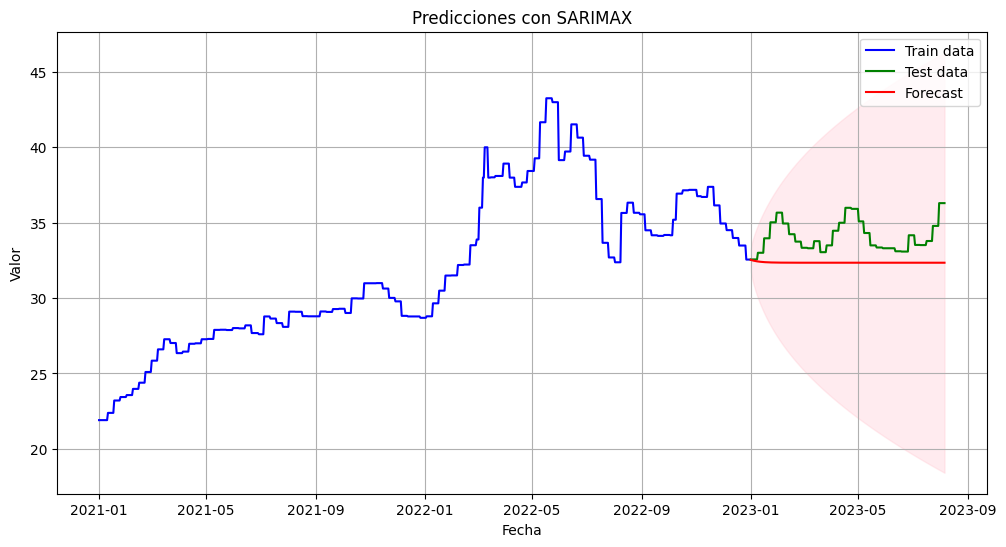

In [85]:
# forecast = resultado_m1.get_prediction(start=promedio_super_test_2, dynamic=False)
forecast = resultado_m1.get_forecast(steps=len(promedio_super_test_2))

# Los resultados incluirán las predicciones, intervalos de confianza y otros detalles útiles:
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Invertir la transformación logarítmica.
#forecast_values_original_scale = np.exp(forecast_values)
# print(forecast_values_original_scale)
forecast_values_original_scale = forecast_values
# Si también aplicaste una diferenciación, debes invertirla también.
d = 1  # Reemplaza esto con el valor de diferenciación utilizado en el modelo SARIMAX.
# forecast_values_original_scale = consumo_diesel.iloc[-d:] + np.cumsum(forecast_values_original_scale)
#print(forecast_values_original_scale)

# # Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(promedio_super_train_2.index, promedio_super_train_2['Superior'], label='Train data', color='blue')
plt.plot(promedio_super_test_2.index, promedio_super_test_2['Superior'], label='Test data', color='green')
plt.plot(promedio_super_test_2.index, forecast_values_original_scale, label='Forecast', color='red')

# Rellenar el área entre los intervalos de confianza superior e inferior.
plt.fill_between(promedio_super_test_2.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones con SARIMAX')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convierte las predicciones a un array numpy
predicciones_array = forecast.predicted_mean.values

# Calcula el MAE (Error Absoluto Medio)
mae = mean_absolute_error(promedio_super_test_2["Superior"], predicciones_array)

# Calcula el MSE (Error Cuadrático Medio)
mse = mean_squared_error(promedio_super_test_2["Superior"], predicciones_array)

# Calcula el RMSE (Raíz del Error Cuadrático Medio)
rmse = np.sqrt(mse)

# Calcula el MAPE (Error Porcentual Absoluto Medio)
mape = np.mean(np.abs((promedio_super_test_2["Superior"] - predicciones_array) / promedio_super_test_2["Superior"])) * 100

print("mae:", mae)
print("mse:", mse)
print("rmse:", rmse)
print("mape:", mape)

mae: 1.7233613594014119
mse: 3.963646388437939
rmse: 1.9908908529695792
mape: 4.9787785487288145


Por medio de las métricas de desempeño se puede observar que no es un modelo tan malo. Sin embargo, en el gráfico se puede observar que la serie de tiempo no se apega para nada a los datos de prueba. Posiblemente los datos predichos y los de prueba no sean tan distintos, pero no sigue el mismo patrón. No es un buen modelo.

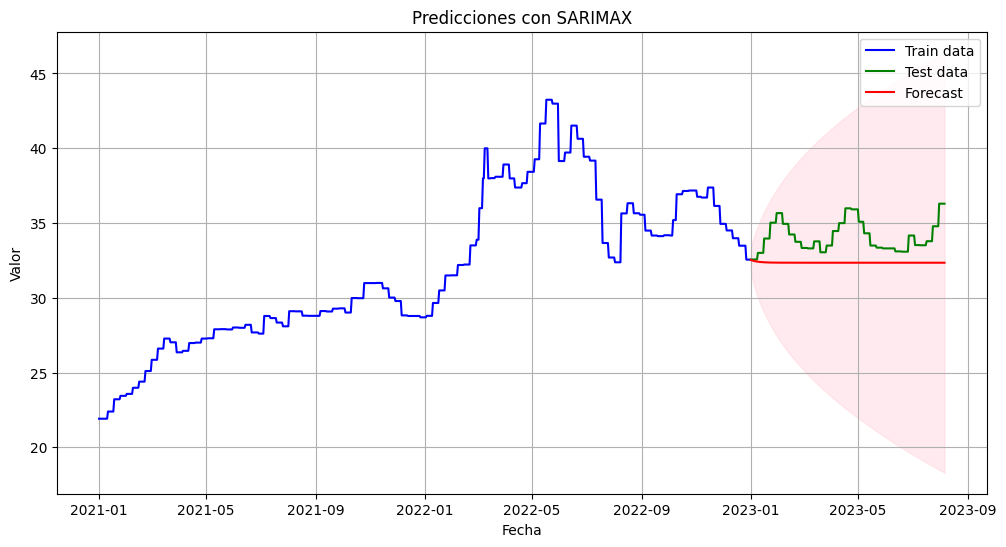

In [87]:
# forecast = resultado_m1.get_prediction(start=promedio_super_test_2, dynamic=False)
forecast = resultado_m2.get_forecast(steps=len(promedio_super_test_2))

# Los resultados incluirán las predicciones, intervalos de confianza y otros detalles útiles:
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Invertir la transformación logarítmica.
#forecast_values_original_scale = np.exp(forecast_values)
# print(forecast_values_original_scale)
forecast_values_original_scale = forecast_values
# Si también aplicaste una diferenciación, debes invertirla también.
d = 1  # Reemplaza esto con el valor de diferenciación utilizado en el modelo SARIMAX.
# forecast_values_original_scale = consumo_diesel.iloc[-d:] + np.cumsum(forecast_values_original_scale)
#print(forecast_values_original_scale)

# # Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(promedio_super_train_2.index, promedio_super_train_2['Superior'], label='Train data', color='blue')
plt.plot(promedio_super_test_2.index, promedio_super_test_2['Superior'], label='Test data', color='green')
plt.plot(promedio_super_test_2.index, forecast_values_original_scale, label='Forecast', color='red')

# Rellenar el área entre los intervalos de confianza superior e inferior.
plt.fill_between(promedio_super_test_2.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones con SARIMAX')
plt.legend()
plt.grid(True)
plt.show()

In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convierte las predicciones a un array numpy
predicciones_array = forecast.predicted_mean.values

# Calcula el MAE (Error Absoluto Medio)
mae = mean_absolute_error(promedio_super_test_2["Superior"], predicciones_array)

# Calcula el MSE (Error Cuadrático Medio)
mse = mean_squared_error(promedio_super_test_2["Superior"], predicciones_array)

# Calcula el RMSE (Raíz del Error Cuadrático Medio)
rmse = np.sqrt(mse)

# Calcula el MAPE (Error Porcentual Absoluto Medio)
mape = np.mean(np.abs((promedio_super_test_2["Superior"] - predicciones_array) / promedio_super_test_2["Superior"])) * 100

print("mae:", mae)
print("mse:", mse)
print("rmse:", rmse)
print("mape:", mape)

mae: 1.7241276418244869
mse: 3.964674627906156
rmse: 1.9911490722460123
mape: 4.9810937690629835


Lo mismo sucede en este segundo modelo. Las métricas no son tan malas, pero en el gráfico se evidencia que no se apega a los valores reales.

Error Cuadrático Medio: 15.139194807037294


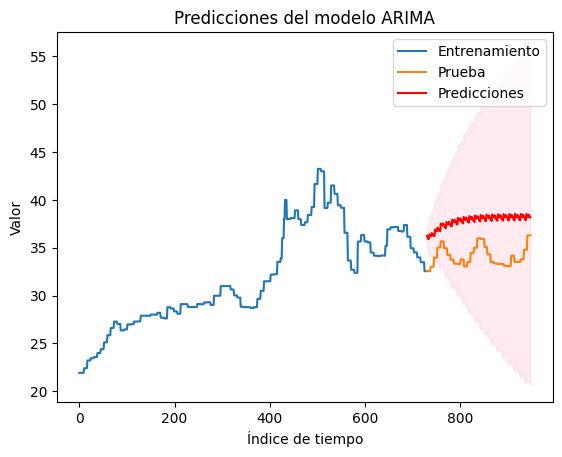

In [89]:
n_forecast = len(promedio_super_test_2)  # Predecir para la longitud del conjunto de prueba
forecast, conf_int = stepwise_fit.predict(n_periods=n_forecast, return_conf_int=True)

# Calcular el error cuadrático medio en las predicciones
mse = mean_squared_error(promedio_super_test_2['Superior'], forecast)

# Imprimir el MSE
print("Error Cuadrático Medio:", mse)
train_index = range(len(promedio_super_train_2))
test_index = range(len(promedio_super_train_2), len(promedio_super_train_2) + len(promedio_super_test_2))

# Graficar los datos reales de entrenamiento y prueba
plt.plot(train_index, promedio_super_train_2, label='Entrenamiento')
plt.plot(test_index, promedio_super_test_2, label='Prueba')

# Graficar las predicciones del modelo
plt.plot(test_index, forecast, label='Predicciones', color='red')

# Agregar intervalos de confianza si están disponibles
if conf_int is not None:
    plt.fill_between(test_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)

# Configurar etiquetas y título
plt.xlabel('Índice de tiempo')
plt.ylabel('Valor')
plt.title('Predicciones del modelo ARIMA')
plt.legend()

# Mostrar la gráfica
plt.show()

Con el modelo usando AutoArima se puede observar que la predicción no es muy buena. El error cuadrático medio no es tan alto, de 15.14, pero en el gráfico se puede observar que no se hace una predicción acertada a los datos de prueba. Lo mismo sucede en los 3 modelos.

### 5. Haga una predicción para todo este año 2023 determine qué tan apegada es a la realidad teniendo en cuenta los meses pasados del año actual.

-0.45000000000000284
-0.45000000000000284
-0.4399999999999977
-0.4399999999999977
-0.4399999999999977
-0.4399999999999977
-0.4399999999999977
-0.4399999999999977
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9600000000000009
0.9600000000000009
0.9600000000000009
0.9600000000000009
0.9600000000000009
0.9600000000000009
0.9600000000000009
2.020000000000003
2.020000000000003
2.020000000000003
2.020000000000003
2.020000000000003
2.020000000000003
2.020000000000003
2.6599999999999966
2.6599999999999966
2.6599999999999966
2.6599999999999966
2.6599999999999966
2.6599999999999966
2.6599999999999966
1.9399999999999977
1.9399999999999977
1.9399999999999977
1.9399999999999977
1.9399999999999977
1.9399999999999977
1.9399999999999977
1.2299999999999969
1.2299999999999969
1.2299999999999969
1.2299999999999969
1.2299999999999969
1.2299999999999969
1.2299999999999969
0.740000000000002
0.740000000000002
0.740000000000002
0.740000000000002
0.740000000000002
0.740000000000002
0.740000000000002
0.3299999999999983
0.32999

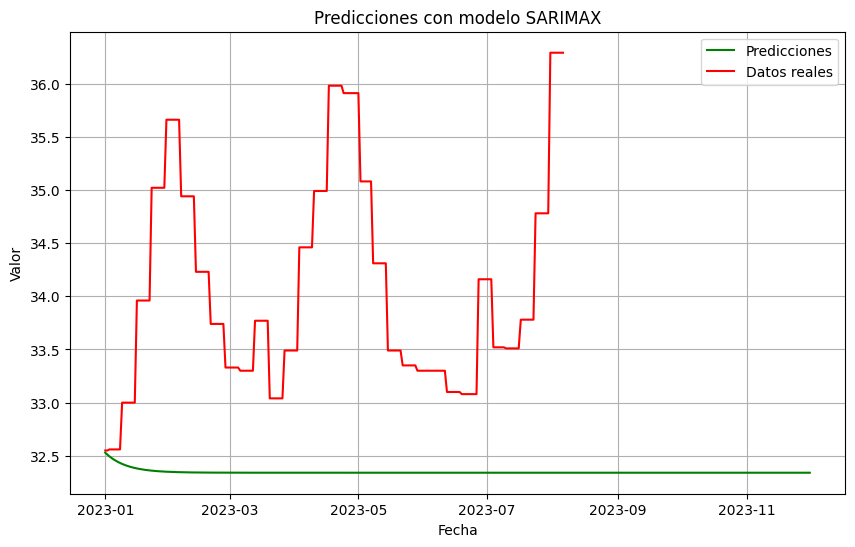

In [90]:
predicciones = resultado_m1.get_prediction(start='2023-01-01', end='2023-12-01', dynamic=False)
predicciones_valores = predicciones.predicted_mean
# print([float("{:.0f}".format(valor)) for valor in predicciones_valores])
# print(promedio_super[promedio_super.index.year == 2023]["Superior"])
i = 0
datos_predichos = [float("{:.0f}".format(valor)) for valor in predicciones_valores]
datos_reales = promedio_super[promedio_super.index.year == 2023]["Superior"]
for fecha, valor in datos_reales.items():
    print(valor - datos_predichos[i])
# print(promedio_super[promedio_super.index.year == 2023]["Superior"] - [float("{:.0f}".format(valor)) for valor in predicciones_valores][0:5])
intervalos_confianza = predicciones.conf_int()
plt.figure(figsize=(10, 6))
plt.plot(predicciones_valores.index, predicciones_valores, label='Predicciones', color='green')
plt.plot(datos_reales.index, datos_reales, label='Datos reales', color='red')

plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones con modelo SARIMAX')
plt.legend()
plt.grid(True)
plt.show()

Un insight interesante en la predicción para el año 2023, es que se puede observar que la diferencia entre los datos reales y predichos no es tan grande. Sin embargo, se evidencia en la gráfica que el modelo para nada sigue la tendencia de aumento que tiene la serie de tiempo. El modelo no es capaz de capturar la naturaleza del precio de la gasolina diario en Guatemala.

### 6. Discuta cuál fue el comportamiento de las series durante la pandemia. ¿Qué tanto afectó las predicciones?¿se recuperaron los valores habituales en el regreso a la “nueva normalidad”?

En la serie de tiempo se puede observar que en 2022 hubo un aumento bastante fuerte en el precio promedio de la gasolina superior. Esto se puede deber al aumento de precios del combustible por la pandemia y también a las restricciones por la guerra entre Rusia y Ucrania. Los precios casi se dispararon en este año, lo cual puede haber afectado el comportamiento de la serie de tiempo, haciendo que no se pudiera hacer una predicción acertada por esta variación. Entonces, la pandemia sí afectó el comportamiento de la serie de tiempo. Los precios no han regresado a la normalidad, siguen altos.